# Investigating the impact of temporal multiplexing on neural population coding

Notebook contains code from CSHL Computational Neuroscience: Vision summer course project.

#### Written July 2022 by CMH

The goal of this project is to apply the findings of Caruso et al. (2018) and to explore the implications of this kind of temporal multiplexing to distributed population codes in visual cortex.  In this notebook I tried one approach wherein I started with IT data I recorded in response to presentation of images and rotated vectors to simulate the response to other images.

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

IT_data = pd.read_csv('ITData.csv').to_numpy() # Starting vector comes from real IT data (objects)

## Step 1: Simulate a neural population

1. Select the recorded response to one image from the IT data. 

2. Simulate the ground truth response to a second vector by defining a new vector a given number of degrees from the first vector. This is done by generating a random vector, orthogonalizing it wrt the first vector and then generating a new vector at a given angle from the first. This does not enforce that the rotated vector must be discrete or that values must be positive.

3. Simulate the response to either stimulus presented alone as random draws with poisson variability from the ground truth vectors. Simulate the response to both images simultaneously using the mixed poisson model tested in Caruso et al.. 


In [2]:
def gen_samples(num_pres, num_units, prop_maj, theta): 

    units_sample = np.random.permutation(len(IT_data))
    a = (IT_data[units_sample[0:num_units], 1]).reshape((num_units, 1))

    # Rotate vector a by specified number of degrees to generate vector b
    rand_vec = np.random.randn(num_units,1) # random vector we can orthogonalize wrt original
    orth_vec = rand_vec - (((rand_vec.T@a)/(a.T@a))*a) # orthogonalize wrt a

    # normalize to unit length
    a_norm = a * (1/ np.linalg.norm(a))
    orth_vec_norm = orth_vec * (1/ np.linalg.norm(orth_vec))

    b = (a_norm * np.cos(np.radians(theta))) + (orth_vec_norm*np.sin(np.radians(theta))) # generate second vector
    b = b * np.linalg.norm(a) # scale new vector up to same size as original

#     # Uncomment to plot histogram of responses to A and B
#     w = 1
#     fig, ax = plt.subplots()
#     ax.hist(a, density=True, facecolor='r', alpha=0.75, label='a', bins=np.arange(min(a), max(a) + w, w), rwidth=0.8)
#     ax.hist(b, density=True, facecolor='b', alpha=0.75, label='b', bins=np.arange(min(b), max(b) + w, w), rwidth=0.8)
#     ax.set_ylabel('Proportion of units')
#     ax.set_xlabel('Spike count')
#     ax.set_title('Distribution of ground truth responses to A and B')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.legend()
#     plt.show()

    # Simulate response of num_pres presentations of each image and images together
    a_draws = np.empty((num_units, num_pres))
    b_draws = np.empty((num_units, num_pres))
    mix_draws = np.empty((num_units, num_pres))
    for i in range(0, num_units):
        if a[i] <= 0 and b[i] > 0:
            a_draws[i, :] = np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres)) * -1
            b_draws[i, :] = np.random.poisson(lam=b[i], size=(1, num_pres))
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres))) * -1 + ((1-prop_maj) * np.random.poisson(lam=b[i], size=(1, num_pres))) # mixture model from Car
        elif a[i] <= 0 and b[i] <= 0: 
            a_draws[i, :] = np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres)) * -1
            b_draws[i, :] = np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres))) * -1 + ((1-prop_maj) * np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1) # mixture model from Car
        elif a[i] > 0 and b[i] <= 0:
            a_draws[i, :] = np.random.poisson(lam=a[i], size=(1, num_pres))
            b_draws[i, :] = np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=a[i], size=(1, num_pres))) + ((1-prop_maj) * np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1) # mixture model from Car
        elif a[i] > 0 and b[i] > 0:
            a_draws[i, :] = np.random.poisson(lam=a[i], size=(1, num_pres))
            b_draws[i, :] = np.random.poisson(lam=b[i], size=(1, num_pres))
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=a[i], size=(1, num_pres))) + ((1-prop_maj) * np.random.poisson(lam=b[i], size=(1, num_pres))) # mixture model from Car

    return a_draws, b_draws, mix_draws
            
num_pres = 30 # number of presentations to simulate
num_units = 50 # number of units in the population (max 534 recorded)
prop_maj = 0.7 # likelihood of representing stimulus a vs. stimulus b (<0.5 favors b, >0.5 favors a)
theta = 20 # angle between vectors a and b (deg)
a_draws, b_draws, mix_draws = gen_samples(num_pres, num_units, prop_maj, theta)

To better visualize our data across the num_pres draws, I do PCA and plot the responses in 2D PCA space.

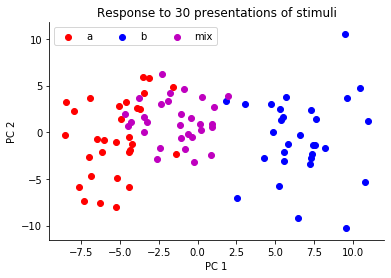

In [3]:
labels = np.concatenate((np.zeros((1, num_pres)), np.zeros((1, num_pres))+1, np.zeros((1, num_pres))+2), axis=1)
all_resp = np.concatenate((a_draws, b_draws, mix_draws), axis=1)

# Fit PCA model from sklearn
pca = PCA(n_components=2)
pca.fit(all_resp.T)
pc_activations = pca.transform(all_resp.T)

# Plot for visualization
fig, ax = plt.subplots()
c_resp = ['r', 'b', 'm']
f_labels = ['a', 'b', 'mix']

for i in range(0, 3):
    ax.scatter(pc_activations[(labels==i).reshape(num_pres*3,), 0], pc_activations[(labels==i).reshape(num_pres*3,), 1], c=c_resp[i], label=f_labels[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
ax.set_title('Response to %d presentations of stimuli' % num_pres)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=3)
plt.show()


# Step 2: Implement cross-validated linear decoder

Next, we train a cross-validated linear decoder to distinguish stimulus a from stimulus b. On each iteration of cross-validation we train the decoder with the repsonses to 80% of the presesentations of each stimulus. We test with the remaining 20% to determine the performance of the classifier, and we measure the distance of the mixture to the decision boundary on each iteration. 

In [4]:
def cross_validated_decoder(num_pres, num_units, prop_maj, theta):
    num_itr = 1000 # number of iterations of cross-validation

    # Loop through iterations of cross-validation
    mean_perf_a = np.zeros(num_itr,)
    mean_perf_b = np.zeros(num_itr,)
    prop_b = np.zeros(num_itr,)
    for i in range(0, num_itr):
        if i % 50 == 0:
            print('#', end = '')

        a_draws, b_draws, mix_draws = gen_samples(num_pres, num_units, prop_maj, theta) 
        resp_single = np.concatenate((a_draws, b_draws), axis=1)
        label_single = np.concatenate((np.zeros((1, num_pres)), np.zeros((1, num_pres))+1), axis=1).reshape(num_pres*2,)
        X_train, X_test, y_train, y_test = train_test_split(resp_single.T, label_single.T, test_size=0.2)
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred_acc = 1 - np.abs(y_test - pred)
        mean_perf_a[i] = np.mean(pred_acc[y_test==1])
        mean_perf_b[i] = np.mean(pred_acc[y_test==0])

        # run multiplexed signal through model and get predictions
        pred_mp = model.predict(mix_draws.T)
        prop_b[i] = np.mean(pred_mp)
        
    print('')

    return mean_perf_a, mean_perf_b, prop_b

mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder(num_pres, num_units, prop_maj, theta)

print(np.mean(mean_perf_a))
print(np.mean(mean_perf_b))
print(np.mean(prop_b))

####################
0.8738833333333333
0.8764849206349207
0.2649666666666667


# Step 3: Test performance of linear decoder with varying parameters

There are occassional errors with fitting the linear decoder, but the code runs and ignores these few iterations of cross-validation.

In [5]:
default_num_pres = 30 # number of presentations to simulate
default_num_units = 50 # number of units in the population (max 534 recorded)
default_prop_maj = 0.75 # likelihood of representing stimulus a vs. stimulus b (<0.5 favors b, >0.5 favors a)
default_theta = 20 # angle between vectors a and b (deg)

## a. Change number of units

There is something wonky about this. For some reason the decoder assigns really large weights only when there are ~75 units in the population. 

In [6]:
num_units_range = [10, 30, 50, 75, 90, 150, 200, 300]
perf_by_units_a = np.empty((len(num_units_range),))
perf_by_units_b = np.empty((len(num_units_range),))
prop_b_by_units = np.empty((len(num_units_range),))
for i in range(0, len(num_units_range)):
    mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder(default_num_pres, num_units_range[i], default_prop_maj, default_theta)
    perf_by_units_a[i] = np.nanmean(mean_perf_a)
    perf_by_units_b[i] = np.nanmean(mean_perf_b)
    prop_b_by_units[i] = np.nanmean(prop_b)


####################
####################
####################
################

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


####
####################
####################
####################
####################


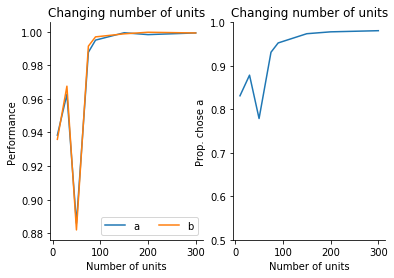

In [9]:
# Plot for visualization
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(num_units_range, perf_by_units_a, label='a')
ax1.plot(num_units_range, perf_by_units_b, label='b')

ax1.set_ylabel('Performance')
ax1.set_xlabel('Number of units')
ax1.set_title('Changing number of units')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend()
ax1.legend(ncol=2)
plt.ylim((0.8, 1))

ax2.plot(num_units_range, 1-prop_b_by_units)

ax2.set_ylabel('Prop. chose a')
ax2.set_xlabel('Number of units')
ax2.set_title('Changing number of units')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.ylim((0.5, 1))

plt.show()


## b. Change angle between vectors

In [10]:
theta_range = [0, 3, 5, 7, 10, 15, 20, 30, 40, 50, 60]
perf_by_units_a = np.empty((len(theta_range),))
perf_by_units_b = np.empty((len(theta_range),))
prop_b_by_units = np.empty((len(theta_range),))
for i in range(0, len(theta_range)):
    mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder(default_num_pres, default_num_units, default_prop_maj, theta_range[i])
    perf_by_units_a[i] = np.nanmean(mean_perf_a)
    perf_by_units_b[i] = np.nanmean(mean_perf_b)
    prop_b_by_units[i] = np.nanmean(prop_b)


####################
####################
####################
####################
################

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


####
####################
####################
####################
####################
####################
####################


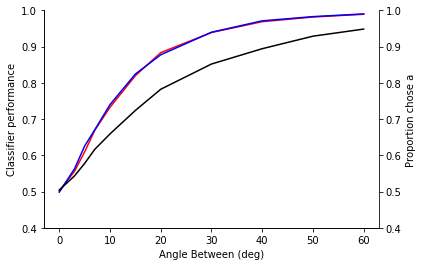

In [11]:
# Plot for visualization
fig, ax1 = plt.subplots()

ax1.plot(theta_range, perf_by_units_a, 'r-', label='a')
ax1.plot(theta_range, perf_by_units_b, 'b-', label='b')

ax1.set_ylabel('Classifier performance')
ax1.set_xlabel('Angle Between (deg)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set(ylim=((0.4, 1)))

ax2 = ax1.twinx()
ax2.plot(theta_range, 1-prop_b_by_units, 'k-')

ax2.set_ylabel('Proportion chose a')
ax2.set_xlabel('Angle Between (deg)')
ax2.spines['top'].set_visible(False)
ax2.set(ylim=((0.4, 1)))

plt.show()


## c. Change bias in the population

In [12]:
propmaj_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
perf_by_units_a = np.empty((len(propmaj_range),))
perf_by_units_b = np.empty((len(propmaj_range),))
prop_b_by_units = np.empty((len(propmaj_range),))
for i in range(0, len(propmaj_range)):
    mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder(default_num_pres, default_num_units, propmaj_range[i], default_theta)
    perf_by_units_a[i] = np.nanmean(mean_perf_a)
    perf_by_units_b[i] = np.nanmean(mean_perf_b)
    prop_b_by_units[i] = np.nanmean(prop_b)

####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################


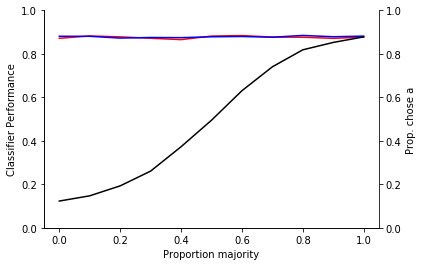

In [13]:
# Plot for visualization
fig, ax1 = plt.subplots()

ax1.plot(propmaj_range, perf_by_units_a, 'r-', label='a')
ax1.plot(propmaj_range, perf_by_units_b, 'b-', label='b')

ax1.set_ylabel('Classifier Performance')
ax1.set_xlabel('Proportion majority')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set(ylim=((0, 1)))

ax2 = ax1.twinx()
ax2.plot(propmaj_range, 1-prop_b_by_units, 'k-')

ax2.set_ylabel('Prop. chose a')
ax2.set_xlabel('Proportion majority')
ax2.spines['top'].set_visible(False)
ax2.set(ylim=((0, 1)))

plt.show()

## d. Change angle between and bias

In [14]:
theta_test = [0, 10, 20, 30, 40, 50]
propMaj_test = [0, 0.2, 0.4, 0.6, 0.8, 1]
perf_by_units_a = np.empty((len(propMaj_test),len(theta_test)))
perf_by_units_b = np.empty((len(propMaj_test),len(theta_test)))
prop_b_by_units = np.empty((len(propMaj_test),len(theta_test)))
for i in range(0, len(propMaj_test)):
    for j in range(0, len(theta_test)):
        mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder(default_num_pres, default_num_units, propMaj_test[i], theta_test[j])
        perf_by_units_a[i, j] = np.nanmean(mean_perf_a)
        perf_by_units_b[i, j] = np.nanmean(mean_perf_b)
        prop_b_by_units[i, j] = np.nanmean(prop_b)


####################
####################
####################
####################
####################
############

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


########
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
########

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


############
####################
####################
############

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


########
################

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


####
####################
####################
##########

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##########
###################

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#
####################
####################
####################
####################
####################


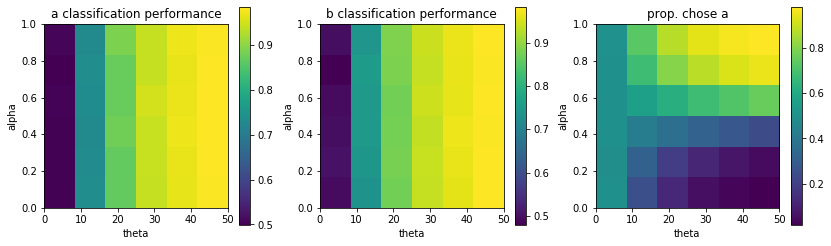

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

a = ax1.imshow(perf_by_units_a, extent=[0, 1, 0, 1])
ax1.set_ylabel('alpha')
ax1.set_xlabel('theta')
ax1.set_title('a classification performance')
ax1.set(ylim=((0, 1)))
t = plt.colorbar(a, ax=ax1)
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels(['0', '10', '20', '30', '40', '50'])

b = ax2.imshow(perf_by_units_b, extent = [0, 1, 0, 1])
ax2.set_ylabel('alpha')
ax2.set_xlabel('theta')
ax2.set_title('b classification performance')
t = plt.colorbar(b, ax=ax2)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_xticklabels(['0', '10', '20', '30', '40', '50'])

c = ax3.imshow(prop_b_by_units, extent = [0, 1, 0, 1])
ax3.set_ylabel('alpha')
ax3.set_xlabel('theta')
ax3.set_title('prop. chose a')
t = plt.colorbar(c, ax=ax3)
ax3.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
t = ax3.set_xticklabels(['0', '10', '20', '30', '40', '50'])
